<a href="https://colab.research.google.com/github/vipul43/image_description/blob/main/MutliModalClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# installs

In [ ]:
# imports
import scipy.io
import cv2
from google.colab.patches import cv2_imshow
from skimage import io
import numpy as np
import pandas as pd
from PIL import Image 
import matplotlib.pylab as plt
import pickle
from skimage import transform
from sklearn.model_selection import train_test_split
import tensorflow as tf
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, LancasterStemmer
import spacy
import nltk
import keras.backend as K

In [ ]:
nltk.download('punkt') #tokenizer
nltk.download('wordnet') #lemmatization

lemmatizer = WordNetLemmatizer() #lemmatizer

sp = spacy.load('en_core_web_sm') #lexical importance find

ls = LancasterStemmer()

In [ ]:
# data loading

!gdown --id 1mrjvJq6XNM8QAgajSgrVGpsj8Vrm3BEm #PASCAL50S

mat = scipy.io.loadmat('/content/pascal50S.mat')
print(type(mat))

Downloading...
From: https://drive.google.com/uc?id=1mrjvJq6XNM8QAgajSgrVGpsj8Vrm3BEm
To: /content/pascal50S.mat
100% 1.12M/1.12M [00:00<00:00, 70.9MB/s]
<class 'dict'>


In [ ]:
classes = ['person',
           'bird', 
           'cat', 
           'cow', 
           'dog', 
           'horse', 
           'sheep', 
           'aeroplane', 
           'bicycle', 
           'boat', 
           'bus', 
           'car', 
           'motorbike', 
           'train', 
           'bottle', 
           'chair', 
           'dining table', 
           'potted plant',
           'sofa', 
           'tv'] #NOUNS

dict_classes = {'person':0, 'man':0, 'human':0,
           'bird':1, 'penguin':1, 'parrot':1, 'sparrow':1,
           'cat':2, 
           'cow':3, 
           'dog':4, 
           'horse':5,
           'sheep':6, 
           'aeroplane':7, 'airplane':7, 'flight':7, 'plane':7, 'jet':7,
           'bicycle':8, 'cycle':8,
           'boat':9, 'ship':9,
           'bus':10, 
           'car':11,
           'motorbike':12, 'bike':12, 'motorcycle':12,
           'train':13, 
           'bottle':14, 'waterbottle':14, 'drinkbottle':14, 'flask':14,
           'chair':15,
           'dining':16, 'diningtable': 16,
           'potted':17, 'plant':17, 'pottedplant': 17,
           'sofa':18, 'couch':18,
           'tv':19, 'monitor':19, 'television':19, 'desktop':19}

In [ ]:
count = {'0':0,   #person
           '1':0, #bird
           '2':0, #cat
           '3':0, #cow
           '4':0, #dog
           '5':0, #horse
           '6':0, #sheep
           '7':0, #aeroplane
           '8':0, #bicycle
           '9':0, #boat
           '10':0, #bus
           '11':0, #car
           '12':0, #motorbike
           '13':0, #train
           '14':0, #bottle
           '15':0, #chair
           '16':0, #dining
           '17':0, #potted plant
           '18':0, #sofa
           '19':0} #tv/monitor

In [ ]:
# observing data
data = []
idx=0
for sample in mat["train_sent_final"][0]:
  # image = io.imread(i[0][0])
  # cv2_imshow(image)
  link = [sample[0][0]] #image link
  cls = set()
  for k in sample[1]:
    for sent in k:
      # if idx==10:
      #   break
      # idx+=1

      for word in sent[0].split():
        pre_word = lemmatizer.lemmatize(ls.stem(word.lower()))
        if(pre_word in dict_classes.keys()):
          cls.add(dict_classes[pre_word])
  for cl in cls:
    count[str(cl)]+=1
  data.append([link, list(cls)])

[[['https://filebox.ece.vt.edu/~vrama91/PASCAL/2008_006488.jpg'], ['boat', 'person']], [['https://filebox.ece.vt.edu/~vrama91/PASCAL/2008_008632.jpg'], ['car', 'train']], [['https://filebox.ece.vt.edu/~vrama91/PASCAL/2008_003378.jpg'], ['car', 'train', 'bus']], [['https://filebox.ece.vt.edu/~vrama91/PASCAL/2008_008048.jpg'], []], [['https://filebox.ece.vt.edu/~vrama91/PASCAL/2008_002567.jpg'], []], [['https://filebox.ece.vt.edu/~vrama91/PASCAL/2008_004441.jpg'], ['car', 'bicycle']], [['https://filebox.ece.vt.edu/~vrama91/PASCAL/2008_002467.jpg'], ['bottle']], [['https://filebox.ece.vt.edu/~vrama91/PASCAL/2008_002395.jpg'], ['dog']], [['https://filebox.ece.vt.edu/~vrama91/PASCAL/2008_006397.jpg'], ['horse', 'person']], [['https://filebox.ece.vt.edu/~vrama91/PASCAL/2008_004621.jpg'], ['sheep']], [['https://filebox.ece.vt.edu/~vrama91/PASCAL/2008_002222.jpg'], ['bus', 'train']], [['https://filebox.ece.vt.edu/~vrama91/PASCAL/2008_007519.jpg'], ['dog']], [['https://filebox.ece.vt.edu/~vrama

In [ ]:
file = open("data.pkl", "wb")
pickle.dump(data, file)
file.close()

In [ ]:
# preprocessing the dataset
'''
data -> url -> image -> array -> resized array
TrainX = array of images resized to (224x224x3)
TrainY = array of labels with size (20x1) in ones-zeros vector like [1, 1, 0, ....]
'''
# TrainX
new_shape = (224, 224, 3)
TrainX = []
encoded_train_images = {}

base_model = tf.keras.applications.Xception(include_top = False)
for point in data:
  photo = io.imread(point[0][0])
  photo = transform.resize(image=photo, output_shape=new_shape)
  TrainX.append(photo)

  batch_photo = np.expand_dims(photo, axis=0)
  preproc_photo = tf.keras.applications.xception.preprocess_input(batch_photo)
  vec_repre_photo = base_model.predict(preproc_photo)
  # vec_repre_photo = np.reshape(vec_repre_photo, vec_repre_photo.shape[1])
  encoded_train_images[point[0][0]] = vec_repre_photo

TrainX = np.array(TrainX)

In [ ]:
# TrainY
TrainY = []
for points in data:
  full_label = np.zeros(shape=(20, ))
  for labels in points[1]:
    i = classes.index(labels)
    full_label[i] = 1
  TrainY.append(full_label)
TrainY = np.array(TrainY)

In [ ]:
with open("encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoded_train_images, encoded_pickle)

In [ ]:
# data splitting
'''
train size: 700 images
val size: 300 images
output: TrainX, TrainY, ValX, ValY
'''
TrainX, ValX, TrainY, ValY = train_test_split(TrainX, TrainY, test_size=0.3, random_state=1)
print("Train X shape: ", TrainX.shape)
print("Train Y shape: ", TrainY.shape)
print("Val X shape: ", ValX.shape)
print("Val Y shape: ", ValY.shape)

Train X shape:  (700, 224, 224, 3)
Train Y shape:  (700, 20)
Val X shape:  (300, 224, 224, 3)
Val Y shape:  (300, 20)


In [ ]:
# instantiate data augmentation
'''
use this 'tf.keras.preprocessing.ImageDataGenerator'
'''
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                          shear_range=0.2, 
                                                          zoom_range=0.2,
                                                          rotation_range=15,
                                                          horizontal_flip=True)

In [ ]:
# model making
# input layer
input = tf.keras.Input(shape=(224, 224, 3), name='input')

# Transfer Learning with VGG16 model with weights as imagenet
vgg16 = tf.keras.applications.VGG16(include_top=False, weights="imagenet", classes=20)
vgg16.trainable = False
x = vgg16(input)

# Dense Layers
x = tf.keras.layers.Flatten(name='flatten')(x)
x = tf.keras.layers.BatchNormalization(name='norm1')(x)
x = tf.keras.layers.Dense(192, activation='relu', name='dense1')(x)
x = tf.keras.layers.BatchNormalization(name='norm2')(x)
x = tf.keras.layers.Dense(84, activation='relu', name='dense2')(x)
x = tf.keras.layers.BatchNormalization(name='norm3')(x)
x = tf.keras.layers.Dense(64, activation='relu', name='dense3')(x)
x = tf.keras.layers.BatchNormalization(name='norm4')(x)

#Output layer
output = tf.keras.layers.Dense(20, activation="sigmoid", name='output')(x)

model = tf.keras.models.Model(inputs=input, outputs=output, name='modelV1')

model.summary()

Model: "modelV1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
norm1 (BatchNormalization)   (None, 25088)             100352    
_________________________________________________________________
dense1 (Dense)               (None, 192)               4817088   
_________________________________________________________________
norm2 (BatchNormalization)   (None, 192)               768       
_________________________________________________________________
dense2 (Dense)               (None, 84)                1621

In [ ]:
# config cell
LR = 0.0009
EPOCHS = 20
BATCH_SIZE = 16
DECAY = LR // EPOCHS
LOSS = tf.keras.losses.BinaryCrossentropy()
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR, decay=DECAY)
METRICS = ['acc']

In [ ]:
# model compiling
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)

In [ ]:
# training
history = model.fit(datagen.flow(TrainX, TrainY, batch_size=BATCH_SIZE), validation_data=datagen.flow(ValX, ValY, batch_size=BATCH_SIZE), epochs=EPOCHS)

Epoch 1/20
44/44 [==============================] - 12s 255ms/step - loss: 0.1644 - acc: 0.3155 - val_loss: 0.2295 - val_acc: 0.0967
Epoch 2/20
44/44 [==============================] - 11s 243ms/step - loss: 0.1580 - acc: 0.3200 - val_loss: 0.2061 - val_acc: 0.3333
Epoch 3/20
44/44 [==============================] - 11s 248ms/step - loss: 0.1513 - acc: 0.3470 - val_loss: 0.2030 - val_acc: 0.1600
Epoch 4/20
44/44 [==============================] - 11s 247ms/step - loss: 0.1506 - acc: 0.3657 - val_loss: 0.2180 - val_acc: 0.1867
Epoch 5/20
44/44 [==============================] - 11s 241ms/step - loss: 0.1456 - acc: 0.3548 - val_loss: 0.1985 - val_acc: 0.1900
Epoch 6/20
44/44 [==============================] - 11s 242ms/step - loss: 0.1427 - acc: 0.3658 - val_loss: 0.1987 - val_acc: 0.2367
Epoch 7/20
44/44 [==============================] - 11s 243ms/step - loss: 0.1504 - acc: 0.3499 - val_loss: 0.2022 - val_acc: 0.2267
Epoch 8/20
44/44 [==============================] - 11s 242ms/step - 

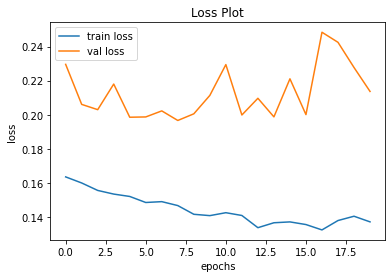

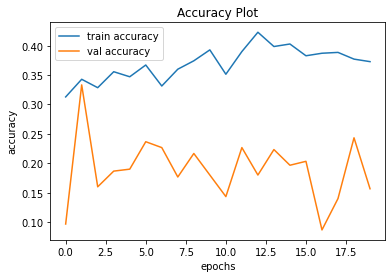

In [ ]:
# plotting curves
'''
loss -> train, val
accuracy -> train, val
'''
plt.plot(list(history.history.values())[0])
plt.plot(list(history.history.values())[2])
plt.title('Loss Plot')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train loss', 'val loss'])
plt.show()

plt.plot(list(history.history.values())[1])
plt.plot(list(history.history.values())[3])
plt.title('Accuracy Plot')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train accuracy', 'val accuracy'])
plt.show()

In [ ]:
# random predictions on val dataset

rnd = np.random.randint(0, len(ValX))
point = ValX[rnd]
label = ValY[rnd]
pred = model.predict(np.asarray([point]))
pred = (pred > 0.5)
pred = pred.astype(int)
print("True Label:", label)
print("Predicted Label:", pred)

True Label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Predicted Label: [[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
